# Advanced Methods in Natural Language Processing - Final Project
## Predicting Movie Genres from Movie Descriptions
### Nikita Baklazhenko, Miguel Conner, David Vallmanya, Dominik Wielath

For our final project, we analyzed a data set of movie descriptions from the Internet Movie Database (IMDb) posted on Kaggle. The data set contains, besides the movie description also, its title, the year it was published, and its genre. Our project aims to predict the genre of a movie based on its description. In particular, we compare different methods regarding their predictive power, strengths, and limitations. 



In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import re 


from collections import Counter
from helper_functions import *

# Natural language Toolkit
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem import SnowballStemmer                                   # Porter's II Stemmer
from nltk import word_tokenize                                          # Document tokenizer
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer


from sklearn import metrics
from sklearn.metrics import f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import GRU, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/davovapo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/davovapo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/davovapo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2023-03-31 22:40:03.206498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 22:40:03.957654: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD

# Load Data

In [3]:
# Set directory
directory_david = '/run/media/david-vp/davidvp-files/DSMMaster/advanced-nlp/final-proj/Genre Classification Dataset/'
directory_david2 = '/run/media/davovapo/hdd1-dvp/DSMMaster/advanced-nlp/Advanced_NLP_Project/Genre Classification Dataset/'
directory_miguel ='/Users/Miguel/Desktop/BSE/Term2/Advanced NLP/Advanced_NLP_Project/Genre Classification Dataset/'
directory_dominik = ''

directory = directory_david2

In [4]:
# Load training data set
filename ="train_data.txt"

df_train = pd.read_csv(os.path.join(directory, filename), delimiter=":::", encoding='utf-8', header=None)

df_train.drop(columns=df_train.columns[0], axis=1, inplace=True)
df_train.columns =['title', 'genre', 'description']
df_train['genre']=df_train['genre'].apply(lambda x: x.strip())

df_train.head()

/tmp/ipykernel_278382/521048698.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_train = pd.read_csv(os.path.join(directory, filename), delimiter=":::", encoding='utf-8', header=None)


,title,genre,description
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [5]:
# Load testing data set
filename = "test_data_solution.txt"
df_test = pd.read_csv(os.path.join(directory, filename), delimiter=":::", encoding='utf-8', header=None)

df_test.drop(columns=df_test.columns[0], axis=1, inplace=True)
df_test.columns =['title', 'genre', 'description']
df_test['genre']=df_test['genre'].apply(lambda x: x.strip())

df_test.head()

/tmp/ipykernel_278382/2294710050.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_test = pd.read_csv(os.path.join(directory, filename), delimiter=":::", encoding='utf-8', header=None)


,title,genre,description
0,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,Er nu zhai (1955),drama,Before he was known internationally as a mart...


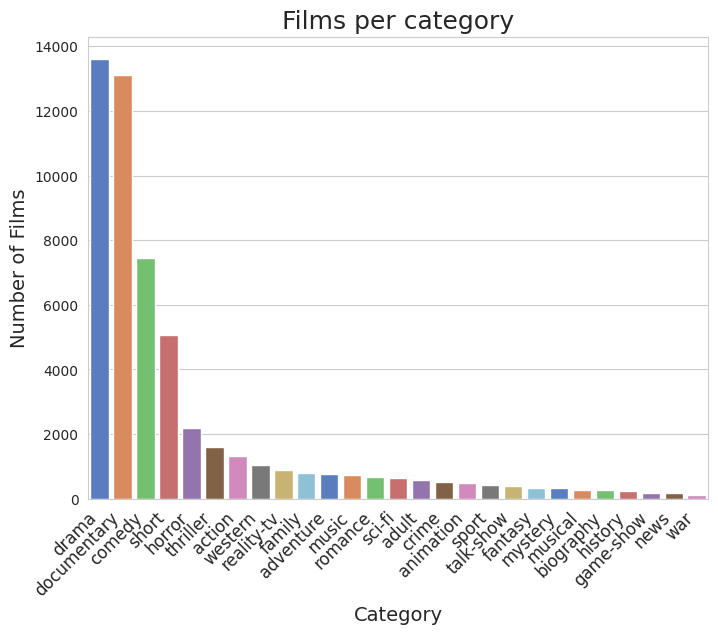

In [6]:
# Create a bar plot of the genre counts
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
sns.barplot(x=df_train.genre.value_counts().index,
            y=df_train.genre.value_counts(),
            palette="muted")

# Customize the plot
plt.title("Films per category", fontsize=18)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Number of Films", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)

# Show the plot
plt.show()

We can see that we have very large class imbalance. There are many movies in few categories while most categories only contain a small number of movies. As we expect our model's performance to correlate with the sample size for each category, we exclude categories with very few numbers of movies within our training set. Further, we exclude genres from which we expect that there might be larger variation in the topics discussed in the description. For example a short film could deal with topics similar to genres like horror or comedy. There is likely no clear pattern. Therefore, we also exclude these categories in our analysis. 

In [6]:
# Only keep some columns
list_labels = ["drama", "comedy", "horror", "thriller", "action", "western", "sci-fi"]

df_train = df_train[df_train["genre"].isin(list_labels)]
df_test = df_test[df_test["genre"].isin(list_labels)]

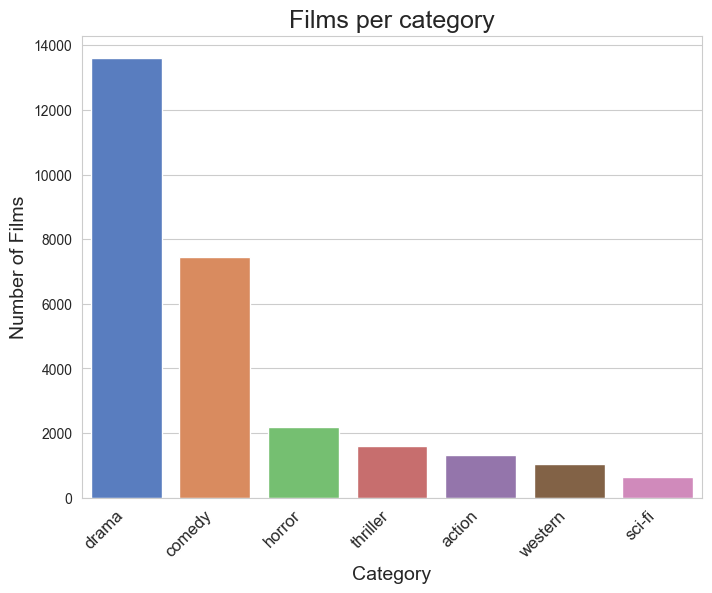

In [7]:
# Create a bar plot of the genre counts
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
sns.barplot(x=df_train.genre.value_counts().index,
            y=df_train.genre.value_counts(),
            palette="muted")

# Customize the plot
plt.title("Films per category", fontsize=18)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Number of Films", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)

# Show the plot
plt.show()

# Preprocessing

## Extract the year from the title and save it as variable in the data frame

In [7]:
df_train["year"] = df_train["title"].apply(get_year)
df_test["year"] = df_test["title"].apply(get_year)

## Remove Stopwords

In [8]:
# Defining stopwords
# using predefined english stopwords
stop_words = set(stopwords.words('english'))

# including additional stopwords
my_stopwords = ['lol', 'people', 'expand',
                'really', 'deal','u', 'much', 'get', 'good', 'act', 'put', 'man', 'a', 'think', 'one',
                'say', 'like', 'go', 'do', 'head', 'yet', 'wall', 'guess', 'keep', 'oh', 'north', 'oil',
                'prize', 'involved', 'might', 'medium''among', 'might', 'make', 'do', 'may', 'year', 'give',
                'also', 'law', 'etc', 'wait', 'prove', 'mean', 'thing', 'rest', 'middle','rnr','u','fuck','make',
                'would', 'know', 'lot', 'see', 'president', 'done', 'even', 'many', 'ever', 'want', 'made',
                'got', 'going', 'need', 'view', 'something', 'lasting', 'still', 'way', 'every', 'anyone', 
                'first', 'look', 'medium', 'time', 'since', 'life', 'probably', 'anything', 'come', 
                'long', 'could', 'anything', 'donald', 'back', 'sure', 'last', 'nothing', 'rate', 'well',
                'left', 'le', 'someone', 'example', 'seen', 'day', 'said', 'world', 'making', 'far', 'care',
                'shit','america','issue','new', 'actually','never','whole','exposed','imapct','side','single']
stop_words.update(my_stopwords)

In [9]:
df_train['description_pp'] = df_train['description'].apply(remove_stopwords, args=(stop_words,))
df_test['description_pp'] = df_test['description'].apply(remove_stopwords, args=(stop_words,))

### Lemmatize

In [10]:
# Tokenize: Split the sentence into words
docs = df_train['description_pp']

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

# Lemmatize list of words and join
lemmatized_output = [''.join([lemmatizer.lemmatize(w) for w in doc]) for doc in docs]
df_train['description_pp'] = lemmatized_output
df_train.head()

,title,genre,description,year,description_pp
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,2009,"Listening conversation doctor parents, 10-year..."
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...,1997,brother sister past incestuous relationship cu...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,1980,bus empties students field trip Museum Natural...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1915,"help unemployed father ends meet, Edith twin s..."
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,2007,film's title refers un-recovered bodies ground...


In [11]:
# Tokenize: Split the sentence into words
docs = df_test['description_pp']

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

# Lemmatize list of words and join
lemmatized_output = [''.join([lemmatizer.lemmatize(w) for w in doc]) for doc in docs]
df_test['description_pp'] = lemmatized_output
df_test.head()

,title,genre,description,year,description_pp
0,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar...",1998,"L.R. Brane loves - car, apartment, job, especi..."
1,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch...",1977,"Spain, March 1964: Quico naughty child three b..."
2,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...,2010,Albin family shepherds Transylvania. direct ci...
3,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi...",2015,"father died, spoken brother 10 years serious c..."
4,Er nu zhai (1955),drama,Before he was known internationally as a mart...,1955,"known internationally martial arts superstar, ..."


# Baseline

## Random assignment based on frequency of genres in the training data

Choose randomly among the genres and use the share of the genres in the training data set as probability that a specific genre is assigned

In [14]:
genre_priors = df_train.genre.value_counts() / df_train.shape[0]
genre_priors = pd.DataFrame(data={"genre":genre_priors.index, "probability": genre_priors.values})
genre_priors = genre_priors.sort_values("genre")

In [15]:
# Predict genres for test data
prior_predictions = np.random.choice(genre_priors.genre.values, size = df_test.shape[0], p = genre_priors.probability.values)
df_test["prior_predictions"] = prior_predictions

In [16]:
# Evaluate prediction performance
true_labels = df_test["genre"]
f1 = f1_score(true_labels, prior_predictions, average="weighted")
recall = recall_score(true_labels, prior_predictions, average="weighted")

print("F1: ",f1)
print("Recall: ",recall)

F1:  0.3270937372375543
Recall:  0.3271440884930326


## Dictionary based prediction

### Frequency (TF) dictionary

Creating an dictionary using the 50 most frequent words per category.

In [17]:
terms_by_genre = {}

# Iterrate over genres
for genre in df_train['genre'].unique():

    # Join descriptions of all movies for each genre
    genre_df = df_train[df_train['genre'] == genre]
    all_descriptions = ' '.join(genre_df['description_pp'])
    all_words = all_descriptions.split()
    word_counts = Counter(all_words)
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    top_words = [word for word, count in sorted_words[:50]]
    terms_by_genre[genre] = top_words

In [18]:
df_test["frequency_prediction"] = dictionary_predictions(df_test, "description_pp", terms_by_genre, genre_priors)

Share of data which was labeled based on dictionary: 0.521
Share of data randomly labled using prior distribution: 0.479


In [19]:
true_labels = df_test["genre"]
f1 = f1_score(true_labels, df_test["frequency_prediction"], average="weighted")
recall = recall_score(true_labels, df_test["frequency_prediction"], average="weighted")

print("F1: ",f1)
print("Recall: ",recall)

F1:  0.40960308989377336
Recall:  0.39261600344778047


### TF-IDF dictionary

In [20]:
# Create a dictionary with the most important words per genre 
genre_descriptions = df_train.groupby(['genre'])['description_pp'].apply(','.join).reset_index()
important_dict_tfidf = create_tfidf_dict(genre_descriptions, 'description_pp', 'genre', 50)

In [21]:
df_test["tfidf_prediction"] = dictionary_predictions(df_test, "description_pp", important_dict_tfidf, genre_priors)

Share of data which was labeled based on dictionary: 0.303
Share of data randomly labled using prior distribution: 0.697


In [22]:
# Evaluate prediction performance
true_labels = df_test["genre"]
f1 = f1_score(true_labels, df_test["tfidf_prediction"], average="weighted")
recall = recall_score(true_labels, df_test["tfidf_prediction"], average="weighted")

print("F1: ",f1)
print("Recall: ",recall)

F1:  0.4081381669716352
Recall:  0.4013072834362879


# GRU Network

In this report we choose a Gated Recurrent Unit (GRU) neural network for our Recurrent Neural Network (RNN) model. GRU neural networks are designed to capture long-term dependencies in sequential data, they use two gate mechanisms to control the flow of information between the hidden states of the network.

On one hand, there's the update gate which helps the model to determine how much of the past information (from previous time steps) needs to be passed along to the future. Finally there's also the reset gate which is used from the model to decide how much of the past information to forget. This allows them to selectively update or forget information from previous time steps, which helps prevent the vanishing gradient problem and allows them to better handle long-term dependencies.

Additionally, we chose a GRU model because they are computationally efficient and have fewer parameters compared to other RNNs like Long Short-Term Memory (LSTM), making them a good choice when we have with limited computational resources.

In [13]:
# input and target columns
X_train = df_train["description_pp"].values
y_train = pd.get_dummies(df_train["genre"]).values

X_test = df_test["description_pp"].values
y_test = pd.get_dummies(df_test["genre"]).values

# find the maximum length of the descriptions or 1200
maxlen = min(max(len(description) for description in X_train), 1200)

In [14]:
# tokenize the input text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [25]:
os.path.isdir('bidir_gru_model')

True

In our case we will build a one bidirectional layer GRU neural network, with a final softmax layer to choose over the 7 possible final classes.

In [26]:
if os.path.isdir('bidir_gru_model'):
    
    model = keras.models.load_model('bidir_gru_model')
    
else:
        
    # define the model architecture
    model = Sequential()
    model.add(Embedding(10000, 64, input_length=maxlen))
    model.add(Bidirectional(GRU(64, dropout=0.12)))
    model.add(Dense(7, activation="softmax"))

    # compile the model
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    
    # train the model
    model.fit(X_train, y_train, epochs=16, batch_size=32, validation_split=0.2)
    
    model.save('bidir_gru_model')

2023-03-30 22:27:46.041277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-30 22:27:46.041549: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/gurobi952/linux64/lib
2023-03-30 22:27:46.041614: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/gurobi952/linux64/lib
2023-03-30 22:27:46.041659: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot o

We can observe a significant improvement over the baseline model with 0.633 and 0.635 values for f1 and recall scores respectively,

In [27]:
# evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)
f1 = f1_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
print("F1 score:", f1)
print("Recall score:", recall)

871/871 [==============================] - 49s 55ms/step
F1 score: 0.6333757062431329
Recall score: 0.6356845280850453


In [28]:
df_test["gru_prediction"] = y_pred

While GRU neural networks are effective in capturing long-term dependencies in sequential data, they also have some limitations. One of them is that they can struggle with handling very long sequences due to the limited memory capacity of the network. In addition, GRUs may not be the best choice for tasks that require explicit modeling of temporal dynamics, as they do not have explicit memory units like LSTMs have. Finally, GRUs can be prone to overfitting if the training data is limited or noisy, and may require additional regularization techniques to address this issue.

# LSTM Network

To compare we also build an equivalent Long Short-Term Memory (LSTM) neural network. LSTMs, like GRUs, are designed to capture long-term dependencies in sequential data. However, unlike GRUs, they use three gate mechanisms instead of 2 to control the flow of information between the hidden states of the network.

The forget gate is used to decide how much of the past information to forget, while the input gate is used to decide how much of the current input to keep. Finally, the output gate determines the amount of output to be produced. This allows LSTMs to selectively update or forget information from previous time steps, which helps prevent the vanishing gradient problem and allows them to better handle long-term dependencies.

In [29]:
if os.path.isdir('bidir_lstm_model'):
    
    model_lstm = keras.models.load_model('bidir_lstm_model')
    
else:
        
    # define the model architecture
    model_lstm = Sequential()
    model_lstm.add(Embedding(10000, 64, input_length=maxlen))
    model_lstm.add(Bidirectional(LSTM(64, dropout=0.12)))
    model_lstm.add(Dense(7, activation="softmax"))

    # compile the model
    model_lstm.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    
    # train the model
    model_lstm.fit(X_train, y_train, epochs=14,batch_size=32, validation_split=0.2)
    
    model_lstm.save('bidir_lstm_model')

We can see how as expected, the LSTM took longer to finish each epoch (204s for LSTM vs 186s for GRU) and also was more resource intensive in terms of RAM. The obtained f1 and recall results are equivalent although we see they are slightly better for LSTM, one of the reasons would be that LSTM has an explicit memory gate unit which makes the model slightly more complex to handle the text classification problem at hand. Also our sequences can be quite long (up to 1200 elements) so LSTM is a little better suited for those long sequences.

In [30]:
# evaluate the model on the test set
y_pred = model_lstm.predict(X_test)
y_pred = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)
f1 = f1_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
print("F1 score:", f1)
print("Recall score:", recall)

871/871 [==============================] - 64s 73ms/step
F1 score: 0.6424811655255757
Recall score: 0.6468539003016808


In [43]:
df_test["lstm_prediction"] = y_pred

In [ ]:
df_test.to_csv("test_predictions.csv")  

## Simple transformer with multi-head attention

Transformer neural networks are also designed to handle sequential data, especially in NLP tasks. They use self-attention mechanisms to capture long-term dependencies in the data by allowing each input element to attend to all other elements in the sequence. A key component of the Transformer network is the multi-head attention layer, which divides the input sequence into multiple heads and learns to attend to different parts of the sequence in each head.

In our simple transformer we use a multi-head attention layer, then layer normalization is applied to the output to ensure that the inputs to subsequent layers have a similar distribution. Global average pooling is then used to extract a fixed-length representation of the sequence from the output of the attention layer. And finally, a dense layer with dropout is used to learn a non-linear mapping from the pooled representation to the output classes.

In [12]:
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

if os.path.isdir('transformer_model'):
    
    model_lstm = keras.models.load_model('transformer_model')
    
else:

    # input and embedding
    inputs = Input(shape=(maxlen,))
    embedding = Embedding(input_dim=10000, output_dim=64)(inputs)

    # multi-head attention layer
    attention = MultiHeadAttention(num_heads=8, key_dim=64)(embedding, embedding)

    # layer normalization to attention layer
    attention = LayerNormalization(epsilon=1e-6)(attention)

    # pooling layer to the output of the attention layer
    pooling = GlobalAveragePooling1D()(attention)

    # dense layer with dropout
    dense = Dense(32, activation="relu")(pooling)
    dropout = Dropout(0.12)(dense)

    # output layer
    outputs = Dense(7, activation="softmax")(dropout)

    model_transformer = Model(inputs=inputs, outputs=outputs)

    optimizer = Adam(learning_rate=1e-3)
    model_transformer.compile(loss="categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

    # train the model
    model_transformer.fit(X_train, y_train, epochs=8, batch_size=32, validation_split=0.2)

    model_transformer.save('transformer_model')

2023-03-31 22:48:14.060538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-31 22:48:14.062804: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/gurobi952/linux64/lib
2023-03-31 22:48:14.064475: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/gurobi952/linux64/lib
2023-03-31 22:48:14.065445: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot o

Transformer models with multi-head attention because have been shown to achieve state-of-the-art results in many NLP tasks. Additionally, Transformers are parallelizable, making them computationally efficient and capable of handling large datasets. 

It is important to note though the jump in computation time from the time needed for training of the LSTM and GRU models. We lowered the input sequence dimension from 1200 for GRU and LSTM to 1000 for the transformer and even then we've gone through 185 seconds per epoch for the GRU and 200 seconds per epoch for the LSTM to 3800 seconds for our simple multihead attention transformer. We've also reduced the number of epochs from 18 and 16 for GRU and LSTM to just 8 for this transformer.

The results have improved significantly from the ~64% f1 and recall score of the LSTM model to the ~70% for the transformer at the cost of a much higher increase in computation time.

In [ ]:
# Evaluate the model on the test set
y_pred = model_transformer.predict(X_test)
y_pred = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)
f1 = f1_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
print("F1 score:", f1)
print("Recall score:", recall)

# BERT

In [65]:
# INSERT BERT model HERE

# Comparison Between Models

For this analysis, we will use a weighted F-1 score to compare between models, but also keep a close eye on the precision and recall of each individual category to make sure we know exactly how our model is predicting.

EQUATION?

One of the consequences of having an unbalanced model is that if our model predicts one larger category very well and one smaller category poorly, then on average the average "macro" F-1 score would be in the middle. However, the weighted F-1 score would be better, since most the larger category is weighted more. This can be a negative because we may begin to ignore smaller categories because our model can still score highly while completely misclassifying movies in our smaller category.

So, with awareness of the potential downsides, we use the wighted F-1 score but also keep an eye on recall and precision for individual categories.

## Confusion Matrices

In [26]:
# Load Test DF with all predictions
df_test = pd.read_csv('/run/media/davovapo/hdd1-dvp/DSMMaster/advanced-nlp/project/Advanced_NLP_Project/test_predictions.csv')
cat_mapper = {0:'action', 1:'comedy', 2:'drama', 3:'horror', 4:'sci-fi', 5:'thriller', 6:'western'}
df_test['gru_prediction'] = df_test['gru_prediction'].map(cat_mapper)
df_test['lstm_prediction'] = df_test['lstm_prediction'].map(cat_mapper)

labs = list(cat_mapper.values())
df_test.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,title,genre,description,year,description_pp,prior_predictions,frequency_prediction,tfidf_prediction,gru_prediction,lstm_prediction,transformer_prediction
0,0,0,0,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar...",1998,"L.R. Brane loves - car, apartment, job, especi...",drama,horror,drama,thriller,drama,drama
1,1,1,1,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch...",1977,"Spain, March 1964: Quico naughty child three b...",comedy,drama,drama,drama,drama,drama
2,2,2,3,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi...",2015,"father died, spoken brother 10 years serious c...",drama,comedy,drama,drama,drama,drama
3,3,3,4,Er nu zhai (1955),drama,Before he was known internationally as a mart...,1955,"known internationally martial arts superstar, ...",comedy,drama,comedy,drama,drama,drama
4,4,4,5,Riddle Room (2016),horror,Emily Burns is being held captive in a room w...,2016,Emily Burns held captive room idea there. Dete...,drama,thriller,horror,comedy,comedy,drama


### Baseline

Our best baseline model, using the weighted F-1 score, is the TF dictionary. So let's take a look at the confusion matrix and error metrics for these predictions.

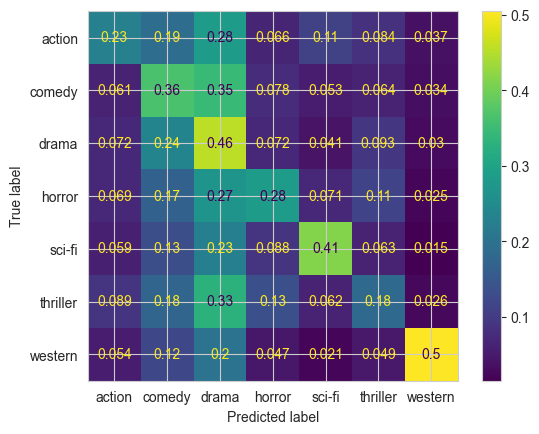

In [12]:
cm = confusion_matrix(df_test['genre'], df_test['frequency_prediction'], labels=labs, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labs)
disp.plot()
plt.show()

In [16]:
# Print the precision and recall, among other metrics
print(metrics.classification_report(df_test['genre'], df_test['frequency_prediction'], digits=3))

              precision    recall  f1-score   support

      action      0.141     0.228     0.174      1314
      comedy      0.386     0.365     0.375      7446
       drama      0.584     0.456     0.512     13612
      horror      0.241     0.284     0.261      2204
      sci-fi      0.164     0.415     0.235       646
    thriller      0.117     0.183     0.143      1590
     western      0.392     0.505     0.441      1032

    accuracy                          0.393     27844
   macro avg      0.289     0.348     0.306     27844
weighted avg      0.440     0.393     0.410     27844



### RNN (LSTM)

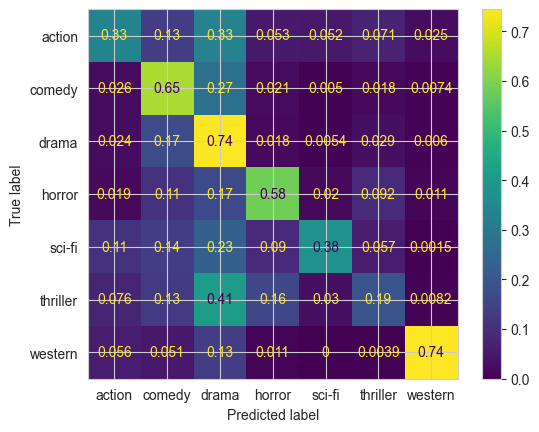

              precision    recall  f1-score   support

      action      0.353     0.335     0.344      1314
      comedy      0.609     0.649     0.628      7446
       drama      0.728     0.745     0.736     13612
      horror      0.618     0.584     0.601      2204
      sci-fi      0.476     0.378     0.421       646
    thriller      0.261     0.193     0.222      1590
     western      0.786     0.743     0.764      1032

    accuracy                          0.647     27844
   macro avg      0.547     0.518     0.531     27844
weighted avg      0.640     0.647     0.642     27844



In [13]:
cm = confusion_matrix(df_test['genre'], df_test['lstm_prediction'], labels=labs, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labs)
disp.plot()
plt.show()

# Print the precision and recall, among other metrics
print(metrics.classification_report(df_test['genre'], df_test['lstm_prediction'], digits=3))

### Simple transformer

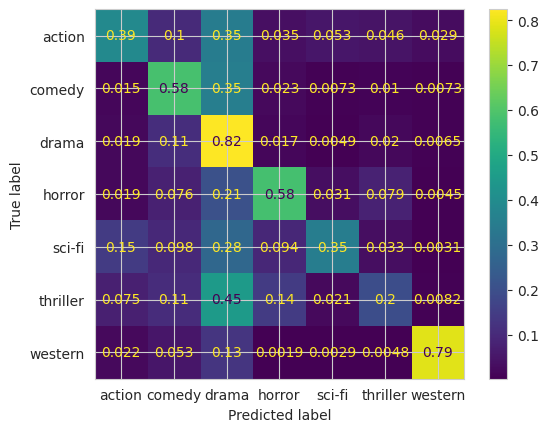

              precision    recall  f1-score   support

      action      0.439     0.390     0.413      1314
      comedy      0.679     0.584     0.628      7446
       drama      0.711     0.825     0.763     13612
      horror      0.635     0.583     0.608      2204
      sci-fi      0.433     0.351     0.388       646
    thriller      0.340     0.196     0.249      1590
     western      0.798     0.787     0.792      1032

    accuracy                          0.672     27844
   macro avg      0.576     0.531     0.549     27844
weighted avg      0.659     0.672     0.661     27844



In [27]:
cm = confusion_matrix(df_test['genre'], df_test['transformer_prediction'], labels=labs, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labs)
disp.plot()
plt.show()

# Print the precision and recall, among other metrics
print(metrics.classification_report(df_test['genre'], df_test['transformer_prediction'], digits=3))

### BERT

In [ ]:
# Insert confusion matrix of BERT results HERE!

# Biases

What are potential biases of our model? Some ideas we had were:
* Perhaps the year a movie came out affects classification accuracy? Are older movies classified worse? (Not really.)
* Does length of description affect classification accuracy? (A little.)

## Year

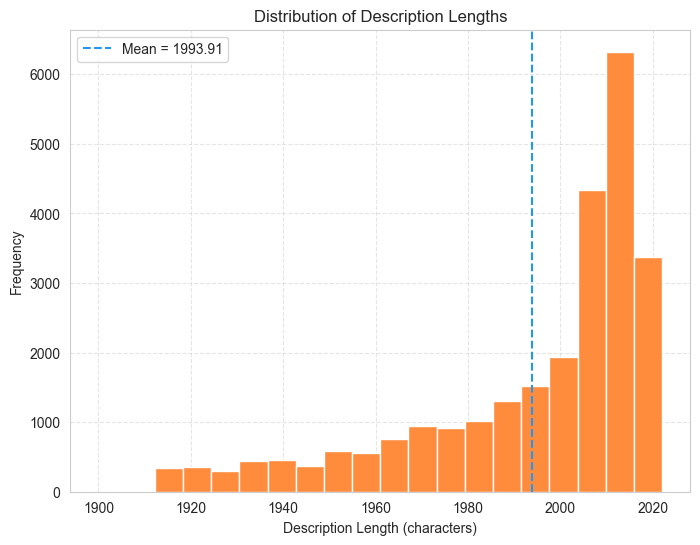

0.25    1982.0
0.50    2005.0
0.75    2013.0
Name: year, dtype: float64

In [63]:
# There are a few movies for which we don't have the year. Remove these.
yrdf = df_test.loc[~(df_test['year'] == 0)]

# Plot a histogram of description lengths.
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(yrdf['year'], bins=20, edgecolor='white', color='#FF8B3D')

# Set chart title and axis labels
ax.set_title('Distribution of Description Lengths')
ax.set_xlabel('Description Length (characters)')
ax.set_ylabel('Frequency')
ax.grid(True, linestyle='--', alpha=0.5)

# Add vertical line for mean value
mean_desc_len = yrdf['year'].mean()
ax.axvline(x=mean_desc_len, color='#2196F3', linestyle='--', label=f'Mean = {mean_desc_len:.2f}')

ax.legend()
plt.show()

yrdf.year.quantile([0.25,0.5,0.75])

In [29]:
yrdf1 = df_test.loc[(1900 < df_test['year']) & (df_test['year'] < 1982)]
yrdf2 = df_test.loc[(2005 > df_test['year']) & (df_test['year'] >= 1982)]
yrdf3 = df_test.loc[(2013 > df_test['year']) & (df_test['year'] >= 2005)]
yrdf4 = df_test.loc[(df_test['year'] >= 2013)]

### TF

In [20]:
f11 = round(f1_score(yrdf1['genre'], yrdf1['frequency_prediction'], average="weighted"),3)
f12 = round(f1_score(yrdf2['genre'], yrdf2['frequency_prediction'], average="weighted"),3)
f13 = round(f1_score(yrdf3['genre'], yrdf3['frequency_prediction'], average="weighted"),3)
f14 = round(f1_score(yrdf4['genre'], yrdf4['frequency_prediction'], average="weighted"),3)
print('Weighted F-1 score for movies that came out:\nbefore 1982:', f11, 
      '\n1982-2005:  ',f12, 
      '\n2005-2013:  ',f13, 
      '\nafter 2013: ',f14)

Weighted F-1 score for movies that came out:
before 1982: 0.449 
1982-2005:   0.421 
2005-2013:   0.42 
after 2013:  0.399


### LSTM

In [21]:
f11 = round(f1_score(yrdf1['genre'], yrdf1['lstm_prediction'], average="weighted"),3)
f12 = round(f1_score(yrdf2['genre'], yrdf2['lstm_prediction'], average="weighted"),3)
f13 = round(f1_score(yrdf3['genre'], yrdf3['lstm_prediction'], average="weighted"),3)
f14 = round(f1_score(yrdf4['genre'], yrdf4['lstm_prediction'], average="weighted"),3)
print('Weighted F-1 score for movies that came out:\nbefore 1982:', f11, 
      '\n1982-2005:  ',f12, 
      '\n2005-2013:  ',f13, 
      '\nafter 2013: ',f14)

Weighted F-1 score for movies that came out:
before 1982: 0.687 
1982-2005:   0.638 
2005-2013:   0.652 
after 2013:  0.63


### Simple transformer

In [30]:
f11 = round(f1_score(yrdf1['genre'], yrdf1['transformer_prediction'], average="weighted"),3)
f12 = round(f1_score(yrdf2['genre'], yrdf2['transformer_prediction'], average="weighted"),3)
f13 = round(f1_score(yrdf3['genre'], yrdf3['transformer_prediction'], average="weighted"),3)
f14 = round(f1_score(yrdf4['genre'], yrdf4['transformer_prediction'], average="weighted"),3)
print('Weighted F-1 score for movies that came out:\nbefore 1982:', f11, 
      '\n1982-2005:  ',f12, 
      '\n2005-2013:  ',f13, 
      '\nafter 2013: ',f14)

Weighted F-1 score for movies that came out:
before 1982: 0.703 
1982-2005:   0.662 
2005-2013:   0.671 
after 2013:  0.645


## Length of Description

In [31]:
df_test['desc_len'] = [len(x) for x in df_test['description']]
a = df_test.desc_len.quantile([0.1,0.2,0.3,.4,.5,.6,.7,.8,.9,1.])
q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 = list(a)

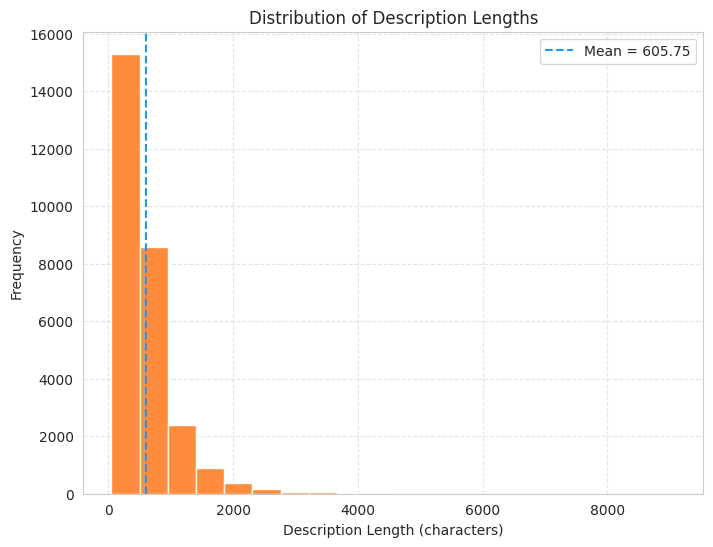

In [33]:
lendf1 = df_test.loc[(df_test['desc_len'] < q1)]
lendf2 = df_test.loc[(q2 > df_test['desc_len']) & (df_test['desc_len'] >= q1)]
lendf3 = df_test.loc[(q3 > df_test['desc_len']) & (df_test['desc_len'] >= q2)]
lendf4 = df_test.loc[(q4 > df_test['desc_len']) & (df_test['desc_len'] >= q3)]
lendf5 = df_test.loc[(q5 > df_test['desc_len']) & (df_test['desc_len'] >= q4)]
lendf6 = df_test.loc[(q6 > df_test['desc_len']) & (df_test['desc_len'] >= q5)]
lendf7 = df_test.loc[(q7 > df_test['desc_len']) & (df_test['desc_len'] >= q6)]
lendf8 = df_test.loc[(q8 > df_test['desc_len']) & (df_test['desc_len'] >= q7)]
lendf9 = df_test.loc[(q9 > df_test['desc_len']) & (df_test['desc_len'] >= q8)]
lendf10 = df_test.loc[(df_test['desc_len'] >= q9)]


# Plot a histogram of description lengths.
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_test['desc_len'], bins=20, edgecolor='white', color='#FF8B3D')

# Set chart title and axis labels
ax.set_title('Distribution of Description Lengths')
ax.set_xlabel('Description Length (characters)')
ax.set_ylabel('Frequency')
ax.grid(True, linestyle='--', alpha=0.5)

# Add vertical line for mean value
mean_desc_len = df_test['desc_len'].mean()
ax.axvline(x=mean_desc_len, color='#2196F3', linestyle='--', label=f'Mean = {mean_desc_len:.2f}')

ax.legend()
plt.show()

### TF

In [36]:
bf11 = round(f1_score(lendf1['genre'], lendf1['frequency_prediction'], average="weighted"),3)
bf12 = round(f1_score(lendf2['genre'], lendf2['frequency_prediction'], average="weighted"),3)
bf13 = round(f1_score(lendf3['genre'], lendf3['frequency_prediction'], average="weighted"),3)
bf14 = round(f1_score(lendf4['genre'], lendf4['frequency_prediction'], average="weighted"),3)
bf15 = round(f1_score(lendf5['genre'], lendf5['frequency_prediction'], average="weighted"),3)
bf16 = round(f1_score(lendf6['genre'], lendf6['frequency_prediction'], average="weighted"),3)
bf17 = round(f1_score(lendf7['genre'], lendf7['frequency_prediction'], average="weighted"),3)
bf18 = round(f1_score(lendf8['genre'], lendf8['frequency_prediction'], average="weighted"),3)
bf19 = round(f1_score(lendf9['genre'], lendf9['frequency_prediction'], average="weighted"),3)
bf110 = round(f1_score(lendf10['genre'], lendf10['frequency_prediction'], average="weighted"),3)
base_f1_by_len = [bf11, bf12, bf13, bf14, bf15, bf16, bf17, bf18, bf19, bf110]
# print('Weighted F-1 score by length of description (# of characters):\n', bf11, 
#       '\n',bf12, 
#       '\n',bf13, 
#       '\n',bf14,
#       '\n',bf15, 
#       '\n',bf16, 
#       '\n',bf17,
#       '\n',bf18,'\n',bf19,
#       '\n',bf110)

### LSTM

In [53]:
lf11 = round(f1_score(lendf1['genre'], lendf1['lstm_prediction'], average="weighted"),3)
lf12 = round(f1_score(lendf2['genre'], lendf2['lstm_prediction'], average="weighted"),3)
lf13 = round(f1_score(lendf3['genre'], lendf3['lstm_prediction'], average="weighted"),3)
lf14 = round(f1_score(lendf4['genre'], lendf4['lstm_prediction'], average="weighted"),3)
lf15 = round(f1_score(lendf5['genre'], lendf5['lstm_prediction'], average="weighted"),3)
lf16 = round(f1_score(lendf6['genre'], lendf6['lstm_prediction'], average="weighted"),3)
lf17 = round(f1_score(lendf7['genre'], lendf7['lstm_prediction'], average="weighted"),3)
lf18 = round(f1_score(lendf8['genre'], lendf8['lstm_prediction'], average="weighted"),3)
lf19 = round(f1_score(lendf9['genre'], lendf9['lstm_prediction'], average="weighted"),3)
lf110 = round(f1_score(lendf10['genre'], lendf10['lstm_prediction'], average="weighted"),3)
lstm_f1_by_len = [lf11, lf12, lf13, lf14, lf15, lf16, lf17, lf18, lf19, lf110]

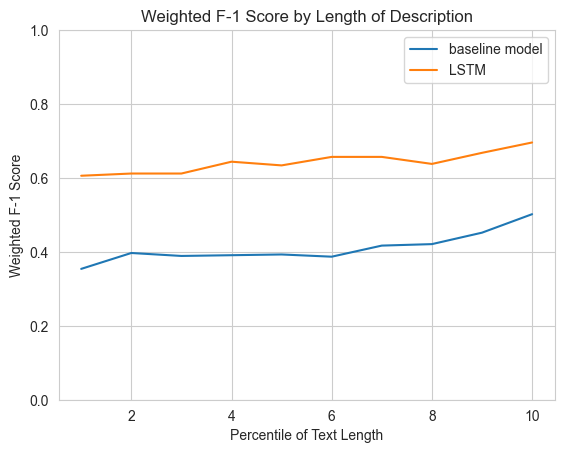

In [64]:
import matplotlib.pyplot as plt

# Sample data
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y1 = [5, 4, 6, 8, 7]
y2 = [2, 4, 3, 1, 5]
y3 = [7, 8, 6, 4, 5]

# Line graphs
plt.plot(x, base_f1_by_len, label='baseline model')
plt.plot(x, lstm_f1_by_len, label='LSTM')
#plt.plot(x, lstm_f1_by_len, label='BERT')


# Set chart title and axis labels
plt.title('Weighted F-1 Score by Length of Description')
plt.xlabel('Percentile of Text Length')
plt.ylabel('Weighted F-1 Score')
plt.ylim(0, 1.0)

# Show legend and grid
plt.legend()
plt.grid(True)

# Display the chart
plt.show()


### Simple transformer

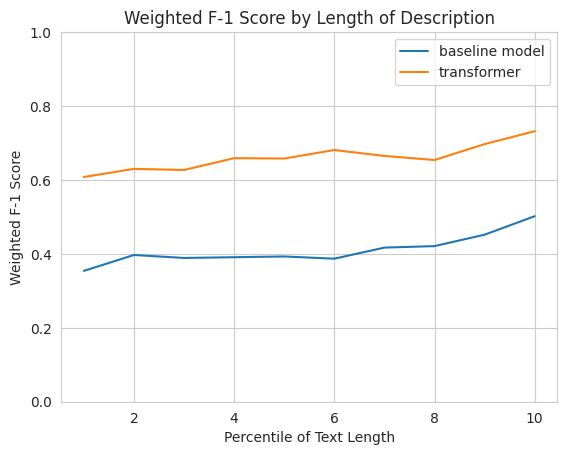

In [38]:
lf11 = round(f1_score(lendf1['genre'], lendf1['transformer_prediction'], average="weighted"),3)
lf12 = round(f1_score(lendf2['genre'], lendf2['transformer_prediction'], average="weighted"),3)
lf13 = round(f1_score(lendf3['genre'], lendf3['transformer_prediction'], average="weighted"),3)
lf14 = round(f1_score(lendf4['genre'], lendf4['transformer_prediction'], average="weighted"),3)
lf15 = round(f1_score(lendf5['genre'], lendf5['transformer_prediction'], average="weighted"),3)
lf16 = round(f1_score(lendf6['genre'], lendf6['transformer_prediction'], average="weighted"),3)
lf17 = round(f1_score(lendf7['genre'], lendf7['transformer_prediction'], average="weighted"),3)
lf18 = round(f1_score(lendf8['genre'], lendf8['transformer_prediction'], average="weighted"),3)
lf19 = round(f1_score(lendf9['genre'], lendf9['transformer_prediction'], average="weighted"),3)
lf110 = round(f1_score(lendf10['genre'], lendf10['transformer_prediction'], average="weighted"),3)
lstm_f1_by_len = [lf11, lf12, lf13, lf14, lf15, lf16, lf17, lf18, lf19, lf110]

import matplotlib.pyplot as plt

# Sample data
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y1 = [5, 4, 6, 8, 7]
y2 = [2, 4, 3, 1, 5]
y3 = [7, 8, 6, 4, 5]

# Line graphs
plt.plot(x, base_f1_by_len, label='baseline model')
plt.plot(x, lstm_f1_by_len, label='transformer')
#plt.plot(x, lstm_f1_by_len, label='BERT')


# Set chart title and axis labels
plt.title('Weighted F-1 Score by Length of Description')
plt.xlabel('Percentile of Text Length')
plt.ylabel('Weighted F-1 Score')
plt.ylim(0, 1.0)

# Show legend and grid
plt.legend()
plt.grid(True)

# Display the chart
plt.show()